In [2]:
%load_ext autoreload
%autoreload 2
import os
import matplotlib.pyplot as plt
import seaborn as sns
from os.path import join
from tqdm import tqdm
import pandas as pd
import imodelsx.process_results
import pickle as pkl
import viz
import sys
import notebook_helper
sys.path.append('../experiments/')
results_dir = '/home/chansingh/mntv1/tree-prompt/feb20'

r = imodelsx.process_results.get_results_df(results_dir)

# fill missing args with default values from argparse
experiment_filename = '../experiments/01_fit.py'
r = imodelsx.process_results.fill_missing_args_with_default(r, experiment_filename)
r['mean_llm_calls'] = notebook_helper.add_mean_llm_calls(r)

# group using these experiment hyperparams when averaging over random seeds
group_keys = [
    k for k in imodelsx.process_results.get_main_args_list(experiment_filename)
    if not k == 'seed'
]
ravg = (
    r
    .groupby(by=group_keys)
    .mean(numeric_only=True)
    .reset_index()
)

100%|██████████| 37/37 [00:03<00:00, 11.96it/s]


In [ ]:
(
    r
    .sort_values(by=['dataset_name', 'model_name', 'num_prompts'], ascending=True)
    .reset_index()
    [['dataset_name', 'model_name', 'num_prompts', 'prompt_source', 'accuracy_test', 'roc_auc_test']]
    .round(3)
)

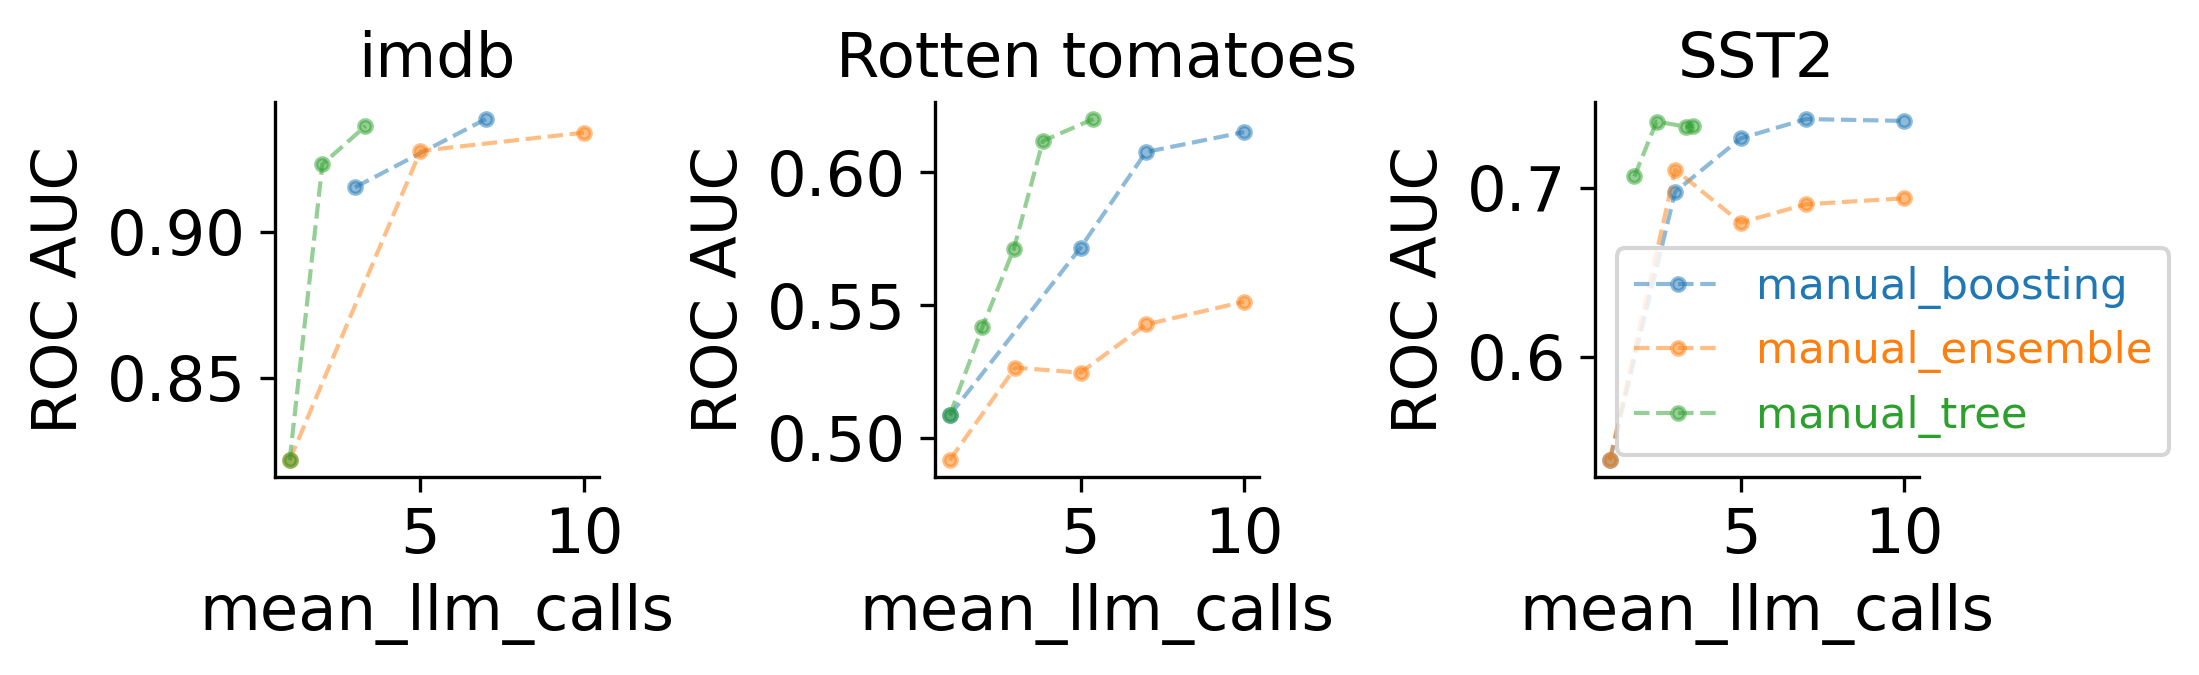

In [35]:
rcurve = ravg[ravg.checkpoint == 'gpt2-xl']

groupings = ['model_name', 'max_features', 'ngrams',
             'refinement_strategy', 'use_llm_prompt_context', 'use_stemming']
metric = 'roc_auc'
# metric = 'accuracy'

viz.plot_perf_curves_individual(rcurve, x='mean_llm_calls')
plt.show()

### Apply cross-validation

In [ ]:
# apply cross validation
ravg_cv = (
    ravg
    .sort_values(by='accuracy_cv', ascending=False)
    .groupby(by=['split_strategy', 'dataset_name'])
    .first()
    .reset_index()
)
ravg_cv

/home/chansingh/.embgam/lib/python3.8/site-packages/IPython/core/pylabtools.py:151: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  fig.canvas.print_figure(bytes_io, **kw)


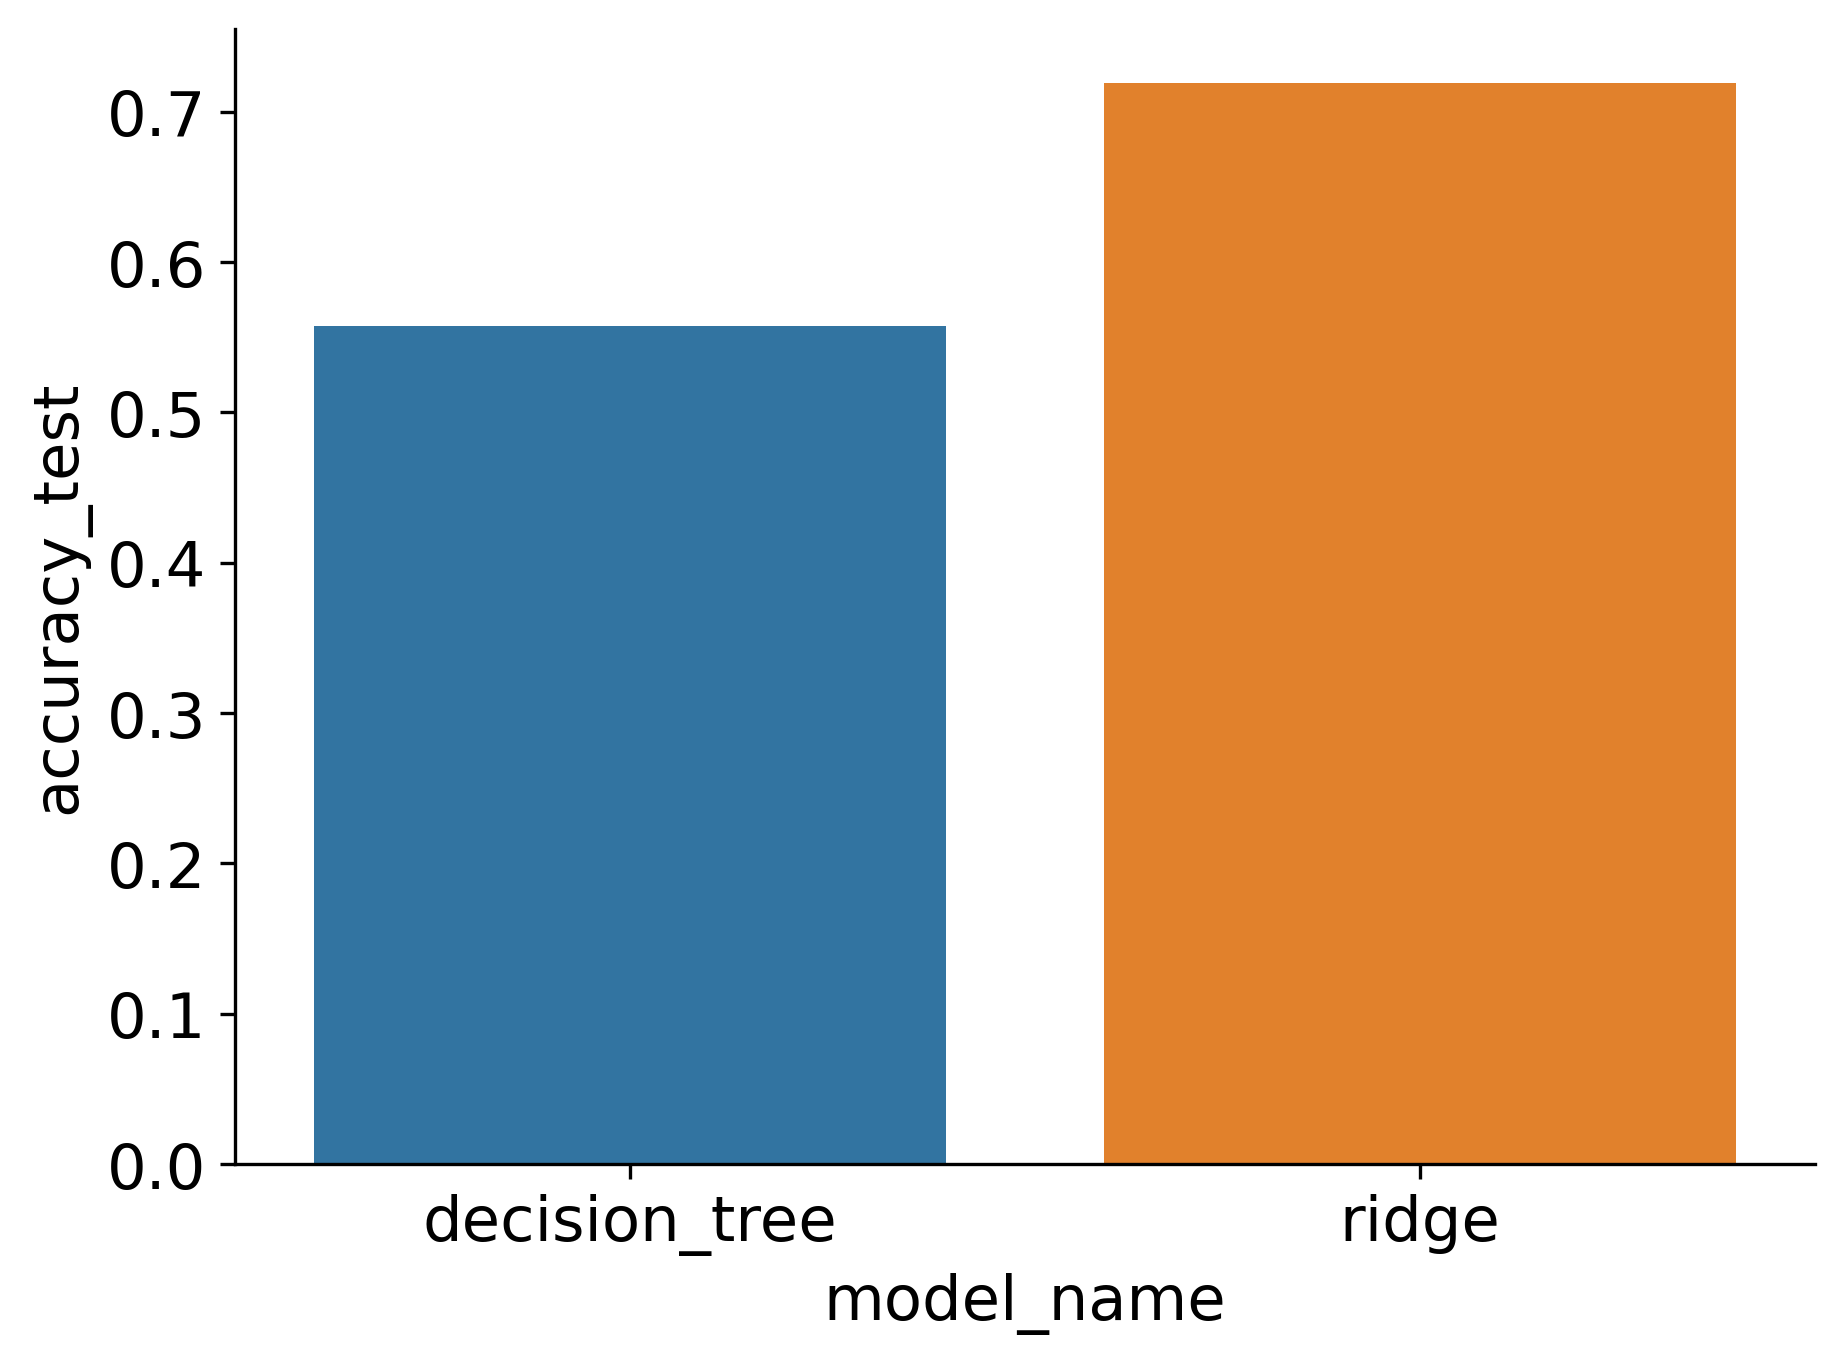

In [9]:
sns.barplot(data=ravg_cv, x='model_name', y='accuracy_test') #, hue='dataset_name')
plt.show()

Load an individual model

In [16]:
run_args = r[r.model_name == 'manual_tree'].iloc[0]
model = pkl.load(open(join(run_args.save_dir_unique, 'model.pkl'), 'rb'))
model

DecisionTreeClassifier(max_leaf_nodes=6, random_state=1)